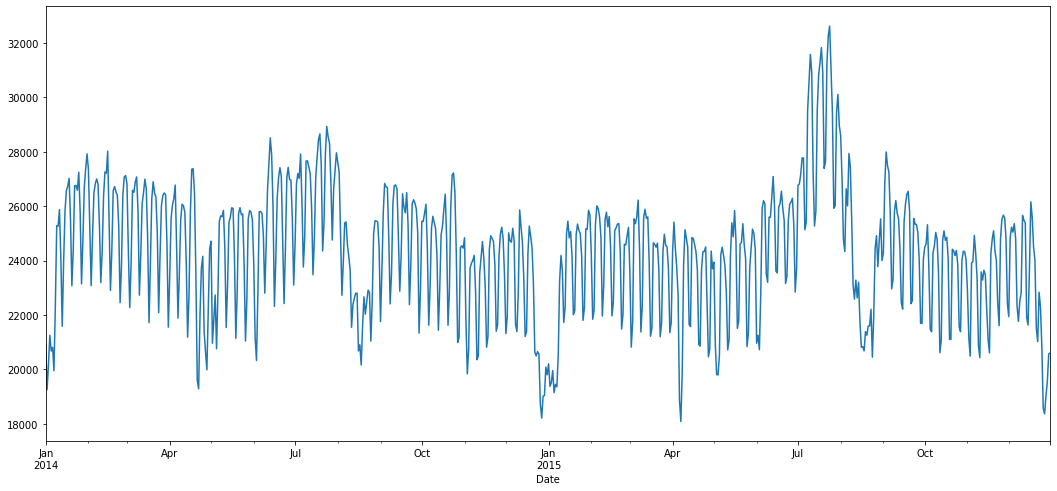

In [6]:
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from pylab import rcParams

df = pd.read_csv("C:\\Users\\stefa\\Desktop\\dsLab\\progetto_finale\\berakbyHour\\italia8mattina.csv")
dates = pd.read_csv("C:\\Users\\stefa\\Desktop\\dsLab\\progetto_finale\\berakbyHour\\date.csv")
df["Date"]=dates["date"]
df = df[["TSTOT.ConsumiITA","Date"]]
df.columns = ['Consumo', 'Date']
df = df.append({'Consumo':37952.91,'Date':'2012-02-29'}, ignore_index = True)
df = df.sort_values(by=['Date']).reindex()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

df = df[-365*2:]

rcParams['figure.figsize'] = 18, 8
df['Consumo'].dropna().plot()

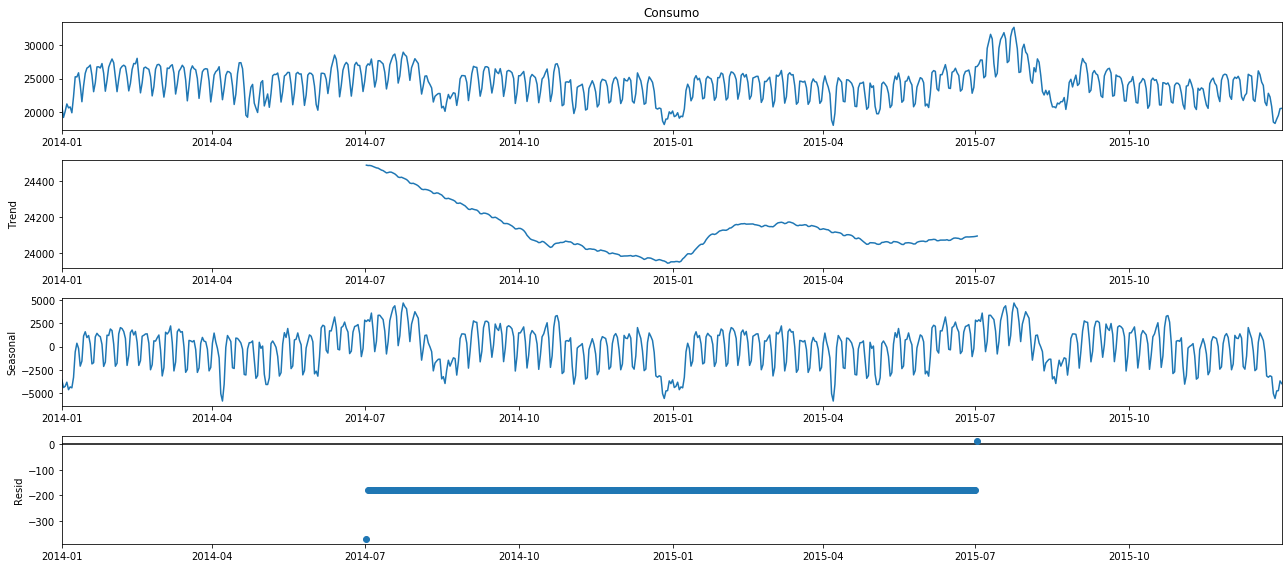

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df["Consumo"].dropna(),freq=365, model='additive')
fig = decomposition.plot()
plt.show()

In [14]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df['Consumo'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.217334
p-value                          0.019003
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64


In [15]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(df['Consumo'])

Results of KPSS Test:
Test Statistic            0.214588
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [16]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [17]:
df = df['Consumo'].resample('D').mean()
df_train = df[:len(df)-7]

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:16641.781095475755
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:15969.328710951013
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:12497.037812250142
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:12327.630984973586
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:12516.181568620395
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:12483.736925436715
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:12349.653977434911
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:12261.221563226834
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:16087.461290668278
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:15810.58659396489
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:12006.383745055895
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:11844.391734321609
ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:12094.009734274112
ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:15746.475870894348
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:11882.20267042116
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:11779.760423685657
ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:12700.994009529126
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:12192.473411166033
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:11831.40152740

In [20]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8585      0.015     58.754      0.000       0.830       0.887
ma.L1          0.1276      0.032      3.960      0.000       0.064       0.191
ar.S.L7        0.2351      0.032      7.287      0.000       0.172       0.298
ma.S.L7       -0.9404      0.017    -55.064      0.000      -0.974      -0.907
sigma2      5.197e+05   1.71e+04     30.467      0.000    4.86e+05    5.53e+05


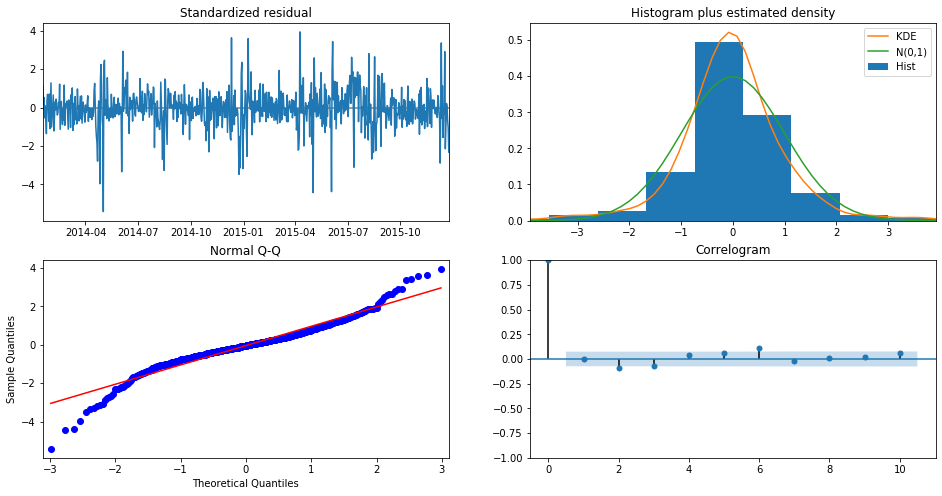

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

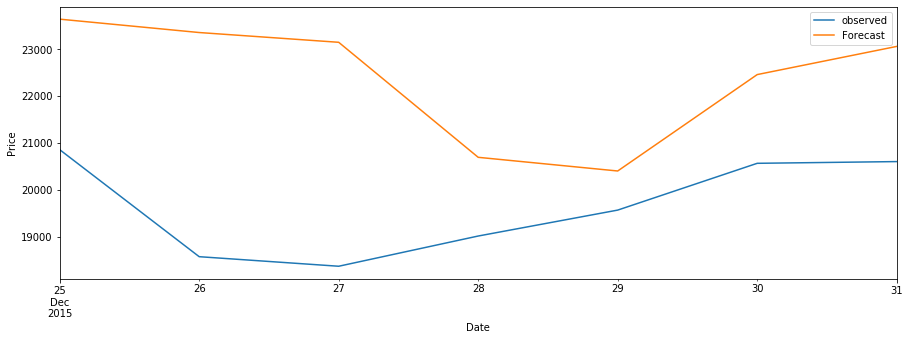

In [14]:
pred_uc = results.get_forecast(steps=7)
pred_ci = pred_uc.conf_int()

ax = df['2015-12-25':].plot(label='observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [15]:
y_truth = df['2015-12-25':]

In [16]:
pred_uc.predicted_mean

2015-12-25    23642.361978
2015-12-26    23356.701625
2015-12-27    23148.310700
2015-12-28    20692.535677
2015-12-29    20400.633914
2015-12-30    22458.919102
2015-12-31    23060.186519
Freq: D, dtype: float64

In [17]:
mse = ((pred_uc.predicted_mean - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 9526309.32


In [18]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3086.47
